### ResNeXt

実装としてはResNetとほぼ同様です。
畳み込み処理を一部grouped convolutionに設定したものとなります。

#### cardinary
$\boldsymbol{x}=[x_1,x_2,\cdots,x_D]$を$D$チャンネルのインプットとします。  
以下のようなネットワークを考えます。入力をチャンネル方向に分割しそれぞれ変換を行い、それを足し合わせるというものです。
$$
F(\boldsymbol{x})=\sum_{i=1}^CT_i(\boldsymbol{x})
$$
$T_i(\boldsymbol{x})$は任意の関数です。
$C$は関数の数でCardinaryと呼びます。  

今回は$T_i$はすべて同じ形式として、bottleneck構造を使います。
それぞれの$T_i$の最初の1×1の畳み込み層ではチャンネル数を減少させます。  
出力$\boldsymbol{y}$は残差接続(Residual connection)を使って、
$$
\boldsymbol{y}=\boldsymbol{x}+\sum_{i=1}^CT_i(\boldsymbol{x})
$$
と書くことができます。

#### grouped convolution
これらの構造はgrouped convolutionを使って簡潔に表すことができます。
それを表したものが下の図です。

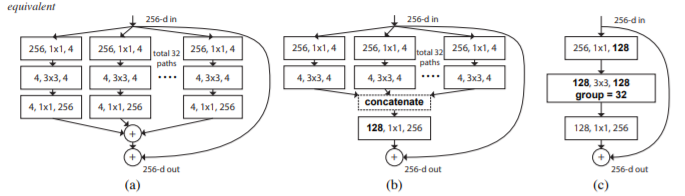

最初の1×1の畳み込み層は1つにまとめることができます。  
そして複数のグループに分けて畳み込みを行い結合する操作は、grouped convolutionで同様の結果を得ることができます。
図の(c)はResNetなどで扱ってきた構造と同じ形になっています。

構造の詳細は以下のようになります。

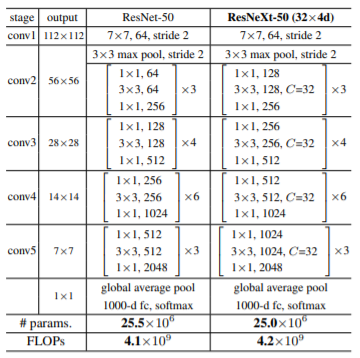

#### 学習
学習はSGDを使用し、weight decayは0.0001でmomentumは0.9、学習率は0.1から始めて文献[11]通りに10で割っていきます。

#### 実装
ResNeXt-50の実装を行います。

In [2]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Add
from keras.layers.merge import concatenate
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10
import numpy as np
import cv2

In [5]:
class conv_bn_relu(Model):
    def __init__(self, out_channels, kernel_size=1, strides=1, groups=1):
        super(conv_bn_relu, self).__init__()
        self.conv = Conv2D(out_channels, kernel_size=kernel_size, strides=strides, groups=groups, padding='same')
        self.bn = BatchNormalization()
        self.relu = Activation("relu")

    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [58]:
class resnext_block(Model):
    def __init__(self, out_channels, groups=1, block_num=0, layer_num=0):
        super(resnext_block, self).__init__(name='block'+'_'+str(block_num)+'_'+str(layer_num))
        block_name = '_'+str(block_num)+'_'+str(layer_num)
        # shortcutとstrideの設定
        if (layer_num == 0):
            # 最初のresblockは(W､ H)は変更しないのでstrideは1にする
            if (block_num==1):
                stride = 1
            else:
                stride = 2
            self.conv_sc = conv_bn_relu(out_channels, kernel_size=1, strides=stride, groups=1)
        else:
            stride = 1
        
        mid_channels=out_channels/2
        
        self.conv1 = conv_bn_relu(out_channels=mid_channels, kernel_size=1, strides=1, groups=groups)
        self.conv2 = conv_bn_relu(out_channels=mid_channels, kernel_size=3, strides=stride, groups=32)
        self.conv3 = conv_bn_relu(out_channels=out_channels, kernel_size=1, strides=1, groups=1)
        
        self.add = Add(name='add'+block_name)
        
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if K.int_shape(x) != K.int_shape(out):
            shortcut = self.conv_sc(x)
        else:
            shortcut = x
        
        out = self.add([out, shortcut])
        return out

In [68]:
class ResNeXt(Model):
    def __init__(self, layers, num_classes=10):
        super().__init__()
        self._layers = []

        # 入力層
        self._layers += [
            conv_bn_relu(out_channels = 64, kernel_size = 7, strides = 2),
            MaxPooling2D(pool_size=3, strides=2, padding='same')
        ]

        # Residualブロック
        for b in np.arange(len(layers)):
            self._layers += [resnext_block(out_channels=256*(2**b), block_num=b+1, layer_num=i) for i in range(layers[b])]

        # 出力層
        self._layers += [
            GlobalAveragePooling2D(name='pool_output'),
            Dense(num_classes, activation='softmax', name='output')
        ]
    
    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x

In [197]:
# 学習率を返す関数を用意する
def lr_schedul(epoch):
    x = 0.1
    if epoch >= 60:
        x = 0.1*0.1
    if epoch >= 120:
        x = 0.1*(0.1**2)
    if epoch >= 160:
        x = 0.1*(0.1**3)
    return x

lr_decay = LearningRateScheduler(
    lr_schedul,
    verbose=1,
)

model = ResNeXt(layers=[3,4,6,3])
sgd = SGD(lr=0.1, momentum=0.9, decay=1e-4, nesterov=False)
model.compile(loss=['categorical_crossentropy'], optimizer=sgd, metrics=['accuracy'])

NameError: name 'SEResNeXt' is not defined

In [69]:
model = ResNeXt(layers=[3,4,6,3])
model.build((None, 224, 224, 3))  # build with input shape.
dummy_input = Input(shape=(224, 224, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "functional_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv_bn_relu_176 (conv_bn_re (None, 112, 112, 64)      9728      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
block_1_0 (resnext_block)    (None, 56, 56, 256)       65792     
_________________________________________________________________
block_1_1 (resnext_block)    (None, 56, 56, 256)       72704     
_________________________________________________________________
block_1_2 (resnext_block)    (None, 56, 56, 256)       72704     
_________________________________________________________________
block_2_0 (resnext_block)    (None, 28, 28, 512)     

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim

import pytorch_lightning as pl
from torchmetrics import Accuracy as accuracy

In [188]:
class conv_bn_relu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, strides=1, groups=1):
        super(conv_bn_relu, self).__init__()
        pad = int((kernel_size-1)/2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=strides, groups=groups, padding=pad)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        return x

In [189]:
class resnext_block(nn.Module):
    def __init__(self, out_channels, groups=1, block_num=0, layer_num=0):
        super(resnext_block, self).__init__()
        # shortcutとstrideの設定
        if (layer_num == 0):
            self._is_change = True
            # 最初のresblockは(W､ H)は変更しないのでstrideは1にする
            if (block_num==1):
                stride = 1
                in_channels = 64
            else:
                stride = 2
                in_channels = int(out_channels//2)
            
            self.conv_sc = conv_bn_relu(in_channels, out_channels, kernel_size=1, strides=stride)
        else:
            self._is_change = False
            stride = 1
            in_channels = out_channels
        
        mid_channels=int(out_channels/2)
        
        
        self.conv1 = conv_bn_relu(in_channels=in_channels, out_channels=mid_channels, kernel_size=1, strides=1, groups=1)
        self.conv2 = conv_bn_relu(in_channels=mid_channels, out_channels=mid_channels, kernel_size=3, strides=stride, groups=groups)
        self.conv3 = conv_bn_relu(in_channels=mid_channels, out_channels=out_channels, kernel_size=1, strides=1, groups=1)

        
    def forward(self, x):
        shortcut = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)

        if self._is_change:
            shortcut = self.conv_sc(shortcut)
        
        out += shortcut
        return out

In [190]:
class ResNeXt(nn.Module):
    def __init__(self, layer_nums, groups, num_classes=10):
        super(ResNeXt, self).__init__()
        
        self.conv1 = nn.Sequential(*[conv_bn_relu(in_channels=3, out_channels=64, kernel_size=7, strides=2, groups=1),
                                     nn.MaxPool2d(kernel_size=3, stride=2,padding=1)])
        
        layers = []
        for b in range(len(layer_nums)):
            layers += [resnext_block(out_channels=256*(2**b), groups=groups, block_num=b+1, layer_num=i) for i in range(layer_nums[b])]
        
        self.resnext = nn.Sequential(*layers)

        self.fc = nn.Sequential(*[nn.AdaptiveAvgPool2d((1,1))])        
        self.linear = nn.Linear(in_features=2048, out_features=num_classes)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.resnext(out)
        out = self.fc(out)
        out = out.view(out.shape[0], -1)
        out = self.linear(out)
        
        return out

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

In [191]:
from torchsummary import summary

summary(ResNeXt(layer_nums=[3,4,6,3], groups=32), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
      conv_bn_relu-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6          [-1, 128, 56, 56]           8,320
       BatchNorm2d-7          [-1, 128, 56, 56]             256
              ReLU-8          [-1, 128, 56, 56]               0
      conv_bn_relu-9          [-1, 128, 56, 56]               0
           Conv2d-10          [-1, 128, 56, 56]           4,736
      BatchNorm2d-11          [-1, 128, 56, 56]             256
             ReLU-12          [-1, 128, 56, 56]               0
     conv_bn_relu-13          [-1, 128, 56, 56]               0
           Conv2d-14          [-1, 256,

In [192]:
class ResNeXtTrainer(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = ResNeXt(layer_nums=[3,4,6,3], groups=32)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch 
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss, 'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'y_hat':y_hat, 'y':y, 'batch_loss': loss.item()*x.size(0)}
    
    def test_step(self, batch, batch_nb):
        x, y = batch
        #x, y = x.to(device), y.to(device)
        y_hat = self.forward(x)
        loss = nn.CrossEntropyLoss()(y_hat, y)
        y_label = torch.argmax(y_hat, dim=1)
        acc = accuracy()(y_label, y)
        return {'test_loss': loss, 'test_acc': acc}
    
    def training_epoch_end(self, train_step_output):
        y_hat = torch.cat([val['y_hat'] for val in train_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in train_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in train_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('train_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', acc, prog_bar=True, on_epoch=True)
        
        print('---------- Current Epoch {} ----------'.format(self.current_epoch + 1))
        print('train Loss: {:.4f} train Acc: {:.4f}'.format(epoch_loass, acc))
    
    def validation_epoch_end(self, val_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in val_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in val_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in val_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('val_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', acc, prog_bar=True, on_epoch=True)
        
        print('valid Loss: {:.4f} valid Acc: {:.4f}'.format(epoch_loss, acc))
    
    # New: テストデータに対するエポックごとの処理
    def test_epoch_end(self, test_step_outputs):
        y_hat = torch.cat([val['y_hat'] for val in test_step_outputs], dim=0)
        y = torch.cat([val['y'] for val in test_step_outputs], dim=0)
        epoch_loss = sum([val['batch_loss'] for val in test_step_outputs]) / y_hat.size(0)
        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy()(preds, y)
        self.log('test_loss', epoch_loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', acc, prog_bar=True, on_epoch=True)
        
        print('test Loss: {:.4f} test Acc: {:.4f}'.format(epoch_loss, acc))
        
    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [180]:
from torch.utils.data import random_split, DataLoader
import torchvision
from torchvision import models, transforms
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt


class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        
        self.dims = (3, 32, 32)
        self.num_classes = 10
    
    def prepare_data(self):
        CIFAR10(self.data_dir, train= True, download= True)
        CIFAR10(self.data_dir, train= False, download= True)
    
    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            cifar_full = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.cifar_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=self.batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


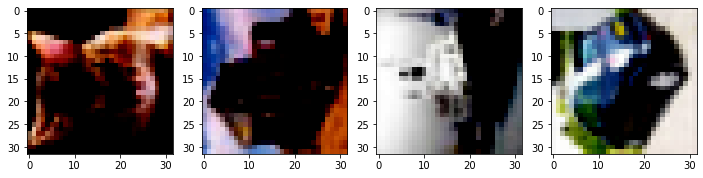

In [181]:
# Init our data pipeline
dm = CIFAR10DataModule(batch_size=32)
# To access the x_dataloader we need to call prepare_data and setup.
dm.prepare_data()
dm.setup()

# Samples required by the custom ImagePredictionLogger callback to log image predictions.
val_samples = next(iter(dm.val_dataloader()))
val_imgs, val_labels = val_samples[0], val_samples[1]

fig, axes = plt.subplots(1, 4, figsize=(12,3))
[axes[i].imshow(val_imgs[i].transpose(0,2)) for i in range(4)];

In [193]:
device='cpu'

net = ResNeXtTrainer().to(device)

trainer = pl.Trainer(gpus=0, max_epochs=5)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [194]:
trainer.fit(net, dm)


  | Name  | Type    | Params
----------------------------------
0 | model | ResNeXt | 23.0 M
----------------------------------
23.0 M    Trainable params
0         Non-trainable params
23.0 M    Total params
92.138    Total estimated model params size (MB)


valid Loss: 2.3084 valid Acc: 0.1250


C:\Users\tanak\anaconda3\envs\tanaka_env1\lib\site-packages\pytorch_lightning\utilities\distributed.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1